In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns
import numpy as np
import collections
from plotnine import *
from mizani.formatters import percent_format
from matplotlib.colors import to_hex as hex_color_code


In [2]:
cmap_reds = plt.colormaps.get_cmap('Reds')
sns.set_palette('Reds')


In [10]:
data = pd.read_csv('movies.csv', index_col=0)
data.head()


,title,year,bt_score,dubious,imdbid,tmdbId,genres,popularity,production_companies,production_countries,...,revenue,vote_average,vote_count,cast,crew,budget,cast_gender,crew_gender,cast_female_representation,crew_female_representation
0,Cinderella,1899,3,0,230,114108,"['Drama', 'Family', 'Fantasy', 'Romance']",3.762,"['Star-Film', 'Georges Méliès']",['France'],...,0.0,6.1,79.0,"[{'adult': False, 'gender': 2, 'id': 11523, 'k...","[{'adult': False, 'gender': 2, 'id': 11523, 'k...",0.0,"[2, 0, 1, 0, 1, 0]","[2, 2, 2, 2]",33.333333,0.000000
1,Gretchen the Greenhorn,1916,3,0,6745,126925,[],1.942,[],[],...,0.0,6.1,7.0,"[{'adult': False, 'gender': 1, 'id': 30779, 'k...","[{'adult': False, 'gender': 2, 'id': 42060, 'k...",0.0,"[1, 2, 2, 2]","[2, 2, 2]",25.000000,0.000000
2,Snow White,1916,3,0,7361,174598,"['Fantasy', 'Drama']",0.817,[],[],...,0.0,5.7,9.0,"[{'adult': False, 'gender': 0, 'id': 1658947, ...","[{'adult': False, 'gender': 2, 'id': 28968, 'k...",0.0,"[0, 1, 2, 2, 0]",[2],20.000000,0.000000
3,The Poor Little Rich Girl,1917,3,0,8443,95866,"['Romance', 'Comedy', 'Drama', 'Fantasy']",2.023,['Artcraft Pictures Corporation'],['United States of America'],...,0.0,5.8,23.0,"[{'adult': False, 'gender': 1, 'id': 100047, '...","[{'adult': False, 'gender': 2, 'id': 13335, 'k...",0.0,"[1, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 1, 1]","[2, 2, 1, 1, 2, 2, 0]",38.461538,28.571429
4,Stella Maris,1918,3,0,9652,70753,['Drama'],1.310,['Mary Pickford Company'],['United States of America'],...,2400000.0,6.9,19.0,"[{'adult': False, 'gender': 1, 'id': 100047, '...","[{'adult': False, 'gender': 1, 'id': 34741, 'k...",0.0,"[1, 1, 2, 2, 1, 0, 0, 2]","[1, 2, 2, 0, 2, 2]",37.500000,16.666667


## **Gráficos simples**

### **Filmes por nota no Teste de Bechdel**
**Métodos utilizados**
- `collections.Counter()`: conta os valores totais das notas de 0 a 3.
- `DataFrame.from_dict(data, orient='index')`: transforma um dicionário em DataFrame. `orient='index'` faz com que as keys do dicionário sejam usadas como index.

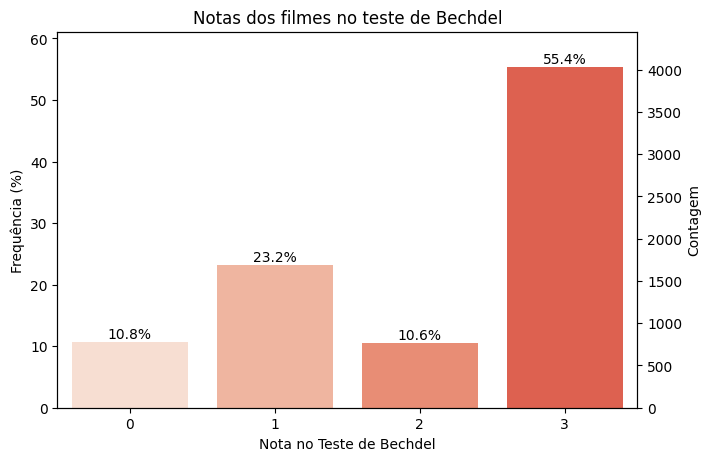

In [18]:
# TOTAL DE FILMES POR NOTA
# score_plot = sns.barplot(x='score', y='total', data=score_df)
fig, ax1 = plt.subplots(figsize=(7, 4.5), constrained_layout=True)

score_plot = sns.barplot( x='bt_score', y='count', data=data.bt_score.value_counts().reset_index(), ax=ax1)
# score_plot.bar_label(score_plot.containers[0])
score_plot.set(title='Notas dos filmes no teste de Bechdel')

xticks_location = [p.get_x() + p.get_width()/2 for p in ax1.patches]
score_plot.set_xticks(xticks_location, np.arange(data['bt_score'].min(), data['bt_score'].max()+1, 1))

ax2 = ax1.twinx()
ax1.yaxis.tick_right()
ax2.yaxis.tick_left()
ax1.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')
ax1.set_ylabel('Contagem')
ax2.set_ylabel('Frequência (%)')
ax1.set_ylim(ax1.get_ylim()[0], 1.05*ax1.get_ylim()[1])
ax2.set_ylim(0, 100*(ax1.get_ylim()[1]/data['bt_score'].count()))

for p in ax1.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax1.annotate('{:.1f}%'.format(100.*y/len(data)), (x.mean(), y+0.5), ha='center', va='bottom', fontsize=10)
    # ax1.annotate(int(y), (x.mean(), y+0.5), ha='center', va='bottom', fontsize=10)

score_plot.set(xlabel='Nota no Teste de Bechdel')
plt.show()


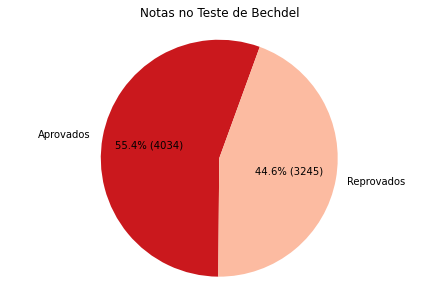

In [74]:
# PORCENTAGEM DOS FILMES
# score_df = df com a quantidade de filmes por nota
fig, axs = plt.subplots(constrained_layout=True)

aprovacao_teste_bechdel = pd.Series([data['bt_score'][data['bt_score'] == 3].value_counts().sum(), data['bt_score'][data['bt_score'] != 3].value_counts().sum()], index=['Aprovados', 'Reprovados'])

graph = axs.pie(aprovacao_teste_bechdel.values, labels=aprovacao_teste_bechdel.index, startangle=70, colors=[cmap_reds(0.75), cmap_reds(0.25)], autopct=lambda p: f'{p:.1f}% ({(p/100)*aprovacao_teste_bechdel.values.sum():n})')
axs.axis('equal')
axs.set_title('Notas no Teste de Bechdel', pad=10)

plt.show()


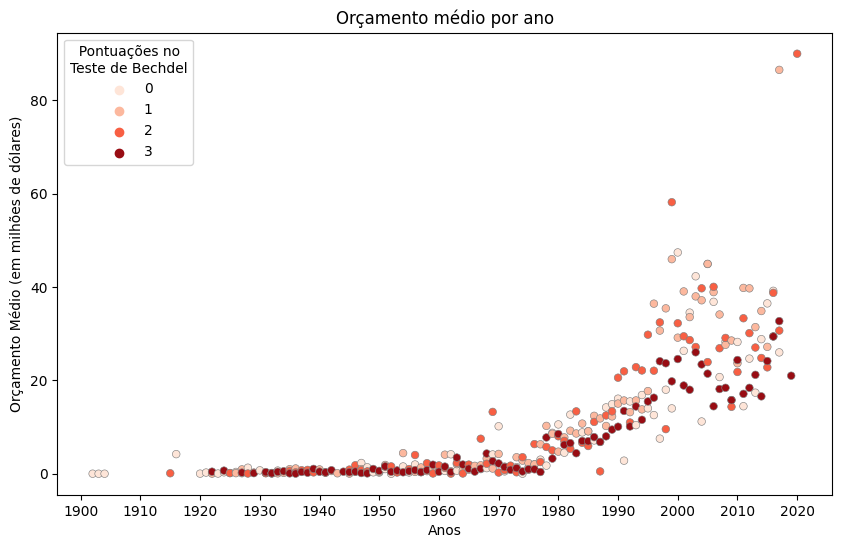

In [22]:
budget_year_mean = data.groupby(['year', 'bt_score'])['budget'].mean().to_frame().reset_index()
budget_year_mean1 = budget_year_mean[budget_year_mean['budget'] > 0]
budget_year_mean2 = budget_year_mean1[budget_year_mean1['year'] >= 1902]
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(y = 'budget', x = 'year', hue = 'bt_score', data=budget_year_mean2, s = 30, edgecolor=".5", palette=[cmap_reds(0.1), cmap_reds(0.26), cmap_reds(0.53), cmap_reds(0.9)])
plt.legend(title = "  Pontuações no\nTeste de Bechdel")
ax.set_xlabel("Anos")
ax.set_ylabel("Orçamento Médio (em milhões de dólares)")
ax.set_title("Orçamento médio por ano")
ax.set_xticks(np.arange(1900, 2020+10, 10))

def numfmt(x, pos):
    s = int(x/10**6)
    return s
yfmt = tkr.FuncFormatter(numfmt)
ax.yaxis.set_major_formatter(yfmt)

plt.show()


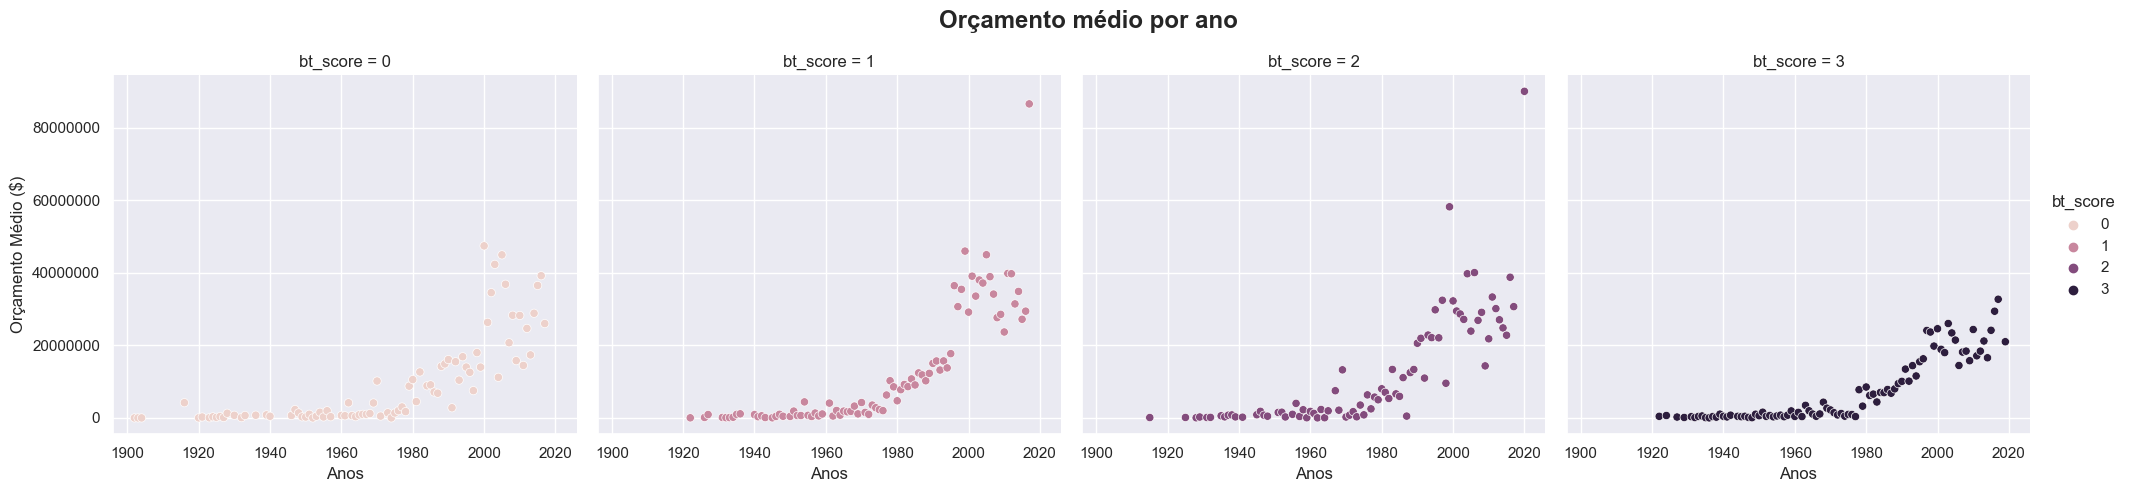

In [23]:
sns.set( rc = {'figure.figsize': (60, 60), 'axes.labelsize': 12})
g = sns.relplot(data = budget_year_mean2, x = "year",  y = "budget", col = "bt_score", hue = "bt_score")
g.fig.suptitle("Orçamento médio por ano", fontsize = 'x-large', fontweight = 'bold')
g.fig.subplots_adjust(top = 0.85)
g.set_axis_labels("Anos" , "Orçamento Médio ($)")
plt.ticklabel_format(style='plain', axis='y')
plt.show()


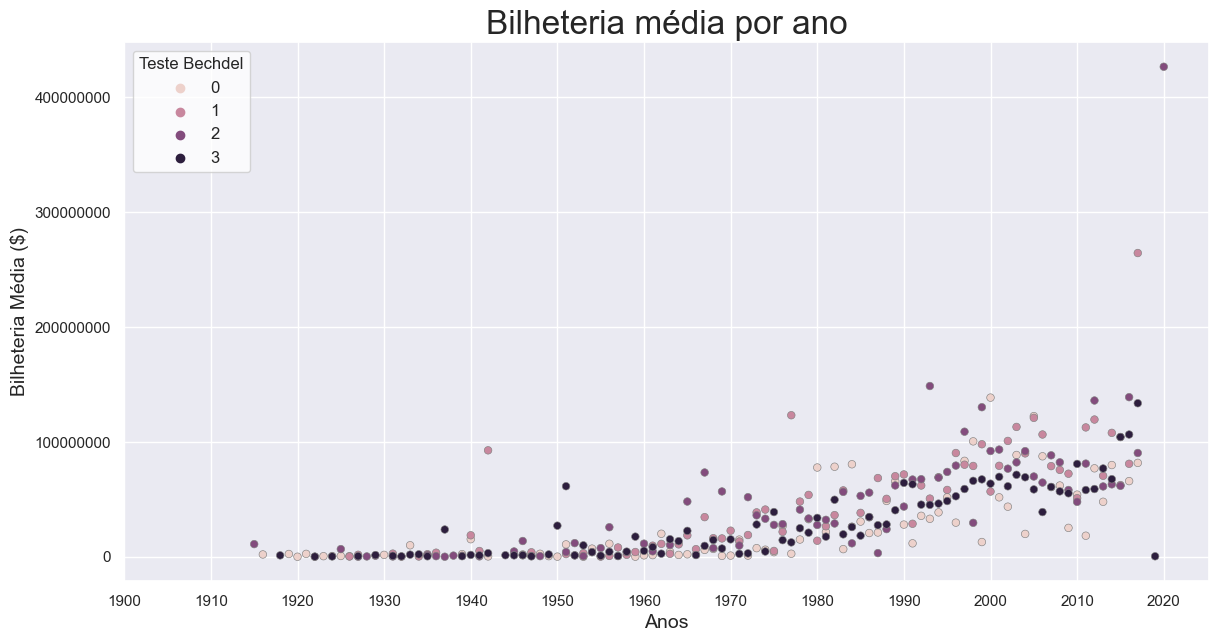

In [26]:
revenue_year_mean = data.groupby(['year', 'bt_score'])['revenue'].mean().to_frame().reset_index()
revenue_year_mean1 = revenue_year_mean[revenue_year_mean['revenue'] > 0]
revenue_year_mean2 = revenue_year_mean1[revenue_year_mean1['year'] >= 1902]
fig, ax = plt.subplots(figsize = (14 , 7))
sns.set_theme(style="ticks")
sns.set_style("white")
sns.scatterplot(y = 'revenue', x = 'year', hue = 'bt_score', data=revenue_year_mean2, s = 30, edgecolor=".5")
plt.legend(title = "Teste Bechdel", fontsize = '12', title_fontsize = "12")
ax.set_xlabel("Anos", size = 14)
ax.set_ylabel("Bilheteria Média ($)", size = 14)
ax.set_title("Bilheteria média por ano", size = 24)
ax.set_xticks([1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])
plt.ticklabel_format(style='plain', axis='y')
plt.show()


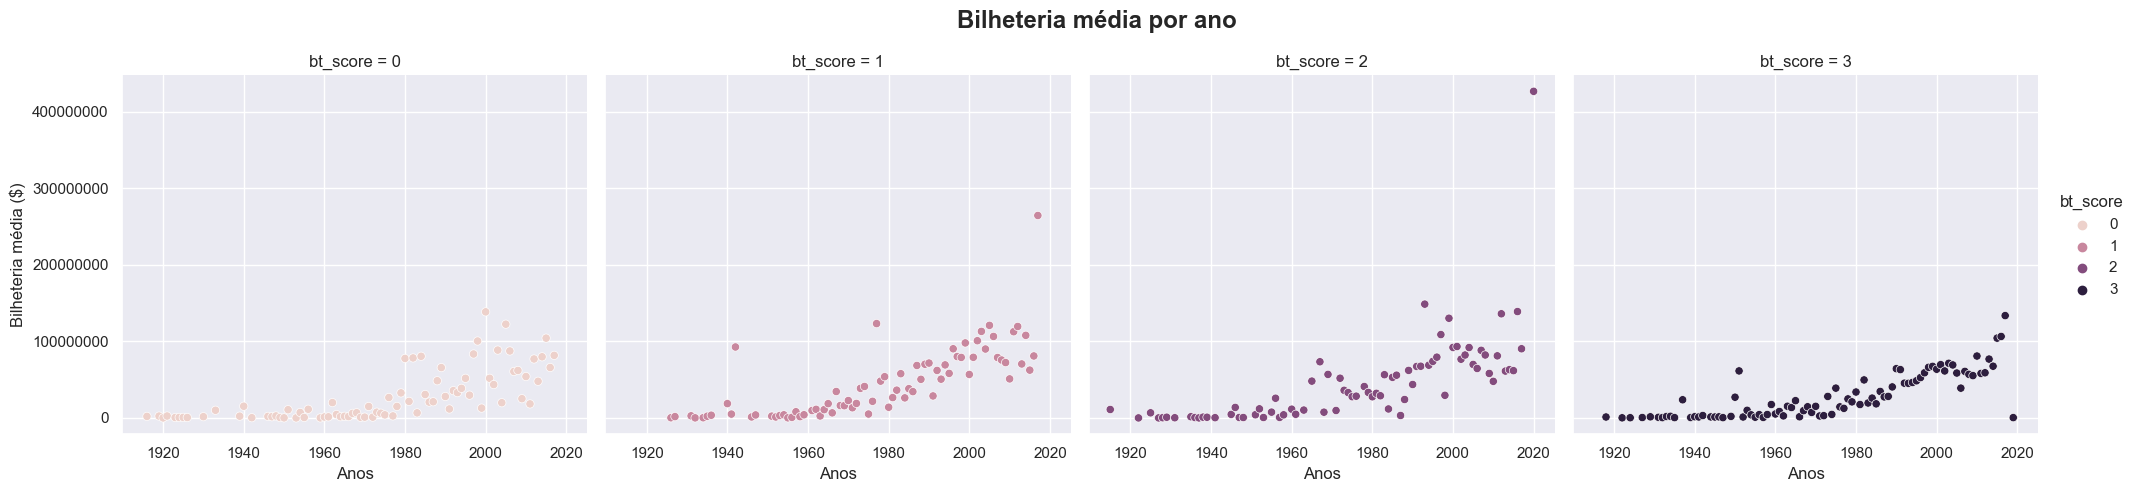

In [27]:
sns.set( rc = {'figure.figsize': (60, 60), 'axes.labelsize': 12})
g = sns.relplot(data = revenue_year_mean2, x = "year",  y = "revenue", col = "bt_score", hue = "bt_score")
g.fig.suptitle("Bilheteria média por ano", fontsize = 'x-large', fontweight = 'bold')
g.fig.subplots_adjust(top = 0.85)
g.set_axis_labels("Anos" , "Bilheteria média ($)")
plt.ticklabel_format(style='plain', axis='y')
plt.show()


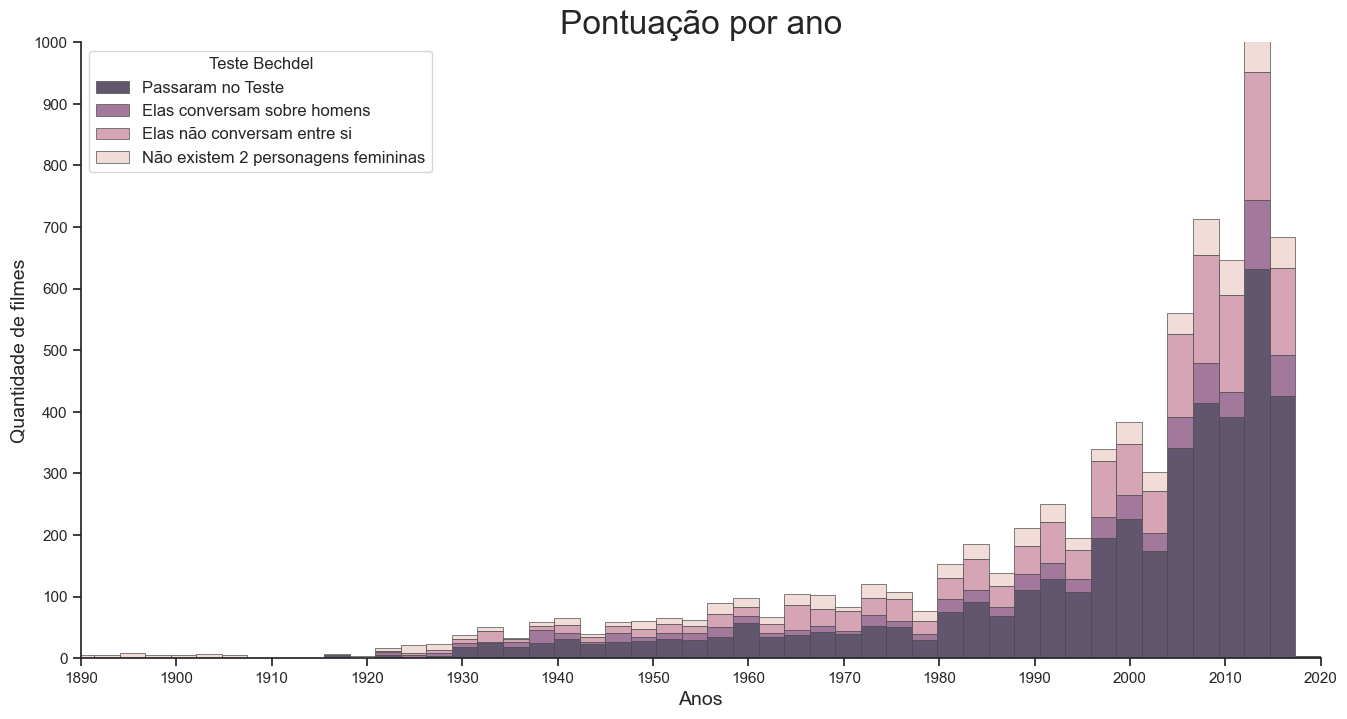

In [30]:
import matplotlib as mpl

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(16, 8))
sns.despine(f)
sns.histplot(data, x="year", hue="bt_score", multiple="stack", edgecolor=".3", linewidth=.5)
plt.legend(labels = ["Passaram no Teste", "Elas conversam sobre homens", "Elas não conversam entre si", "Não existem 2 personagens femininas"],
           title = "Teste Bechdel", fontsize = '12', title_fontsize = "12")
ax.set_xlabel("Anos", size = 14)
ax.set_ylabel("Quantidade de filmes", size = 14)
ax.set_title("Pontuação por ano", size = 24)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])
ax.set_yticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
ax.set_xlim(1890, 2020)
ax.set_ylim(0, 1000)
plt.show()


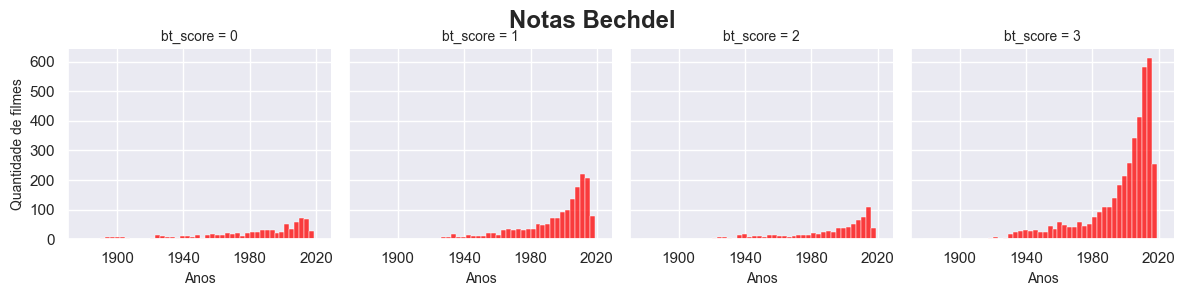

In [31]:
sns.set_theme(style="darkgrid")
sns.set( rc = {'figure.figsize': (60, 60), 'axes.labelsize': 10})
g = sns.displot(data, x="year", col="bt_score", binwidth=3, height=3, facet_kws=dict(margin_titles=True), color='Red')
g.set(xticks=(1900, 1940, 1980, 2020), yticks=(0, 100, 200, 300, 400, 500, 600))
g.fig.suptitle("Notas Bechdel", fontsize = 'x-large', fontweight = 'bold')
g.fig.subplots_adjust(top = 0.85)
g.set_axis_labels("Anos" , "Quantidade de filmes")
plt.show()


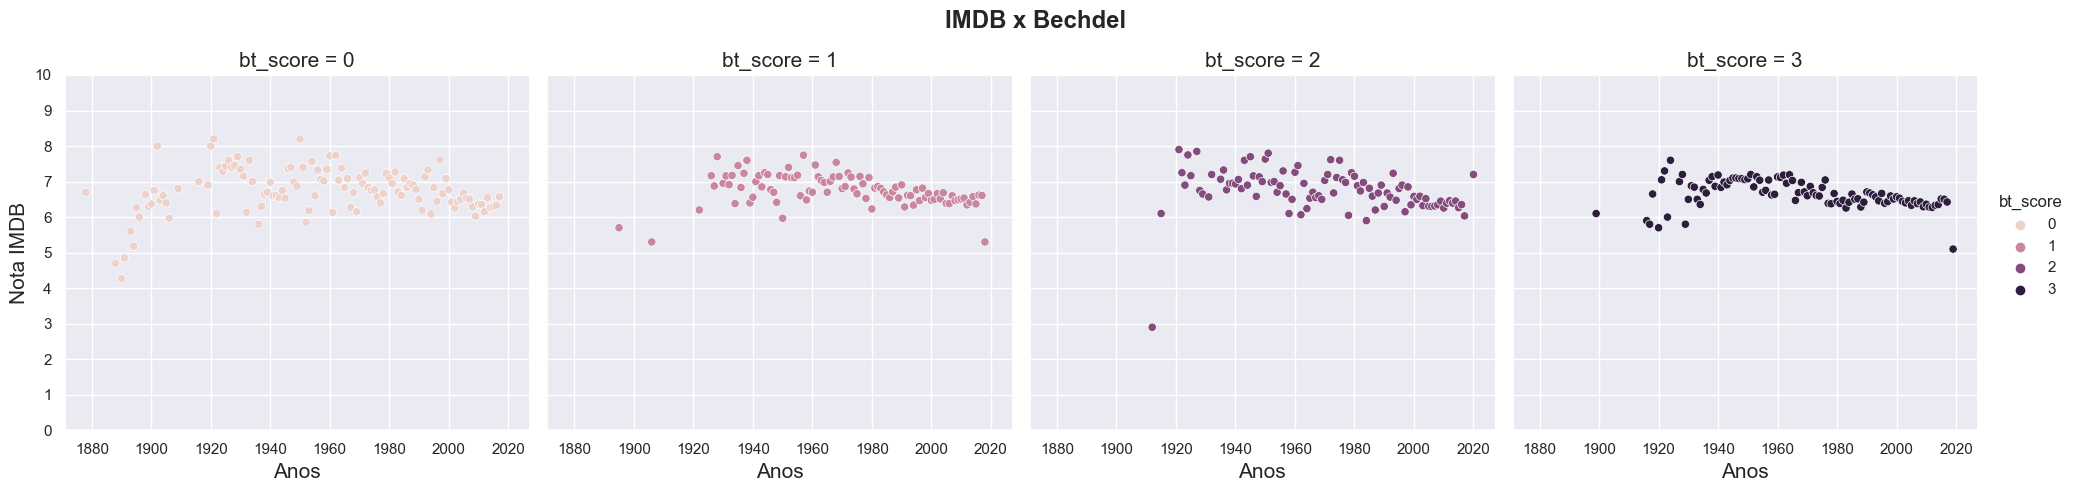

In [35]:
imdb_bechdel = data.groupby(['year', 'bt_score'])['vote_average'].mean().to_frame().reset_index()
sns.set( rc = {'figure.figsize': (60, 60), 'axes.labelsize': 15})
g = sns.relplot(data = imdb_bechdel, x = "year",  y = "vote_average", col = "bt_score", hue = "bt_score")
g.fig.suptitle("IMDB x Bechdel", fontsize = 'x-large', fontweight = 'bold')
g.fig.subplots_adjust(top = 0.85)
g.set_axis_labels("Anos" , "Nota IMDB")
g.set(ylim=(0, 10))
g.set(yticks=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))
plt.show()


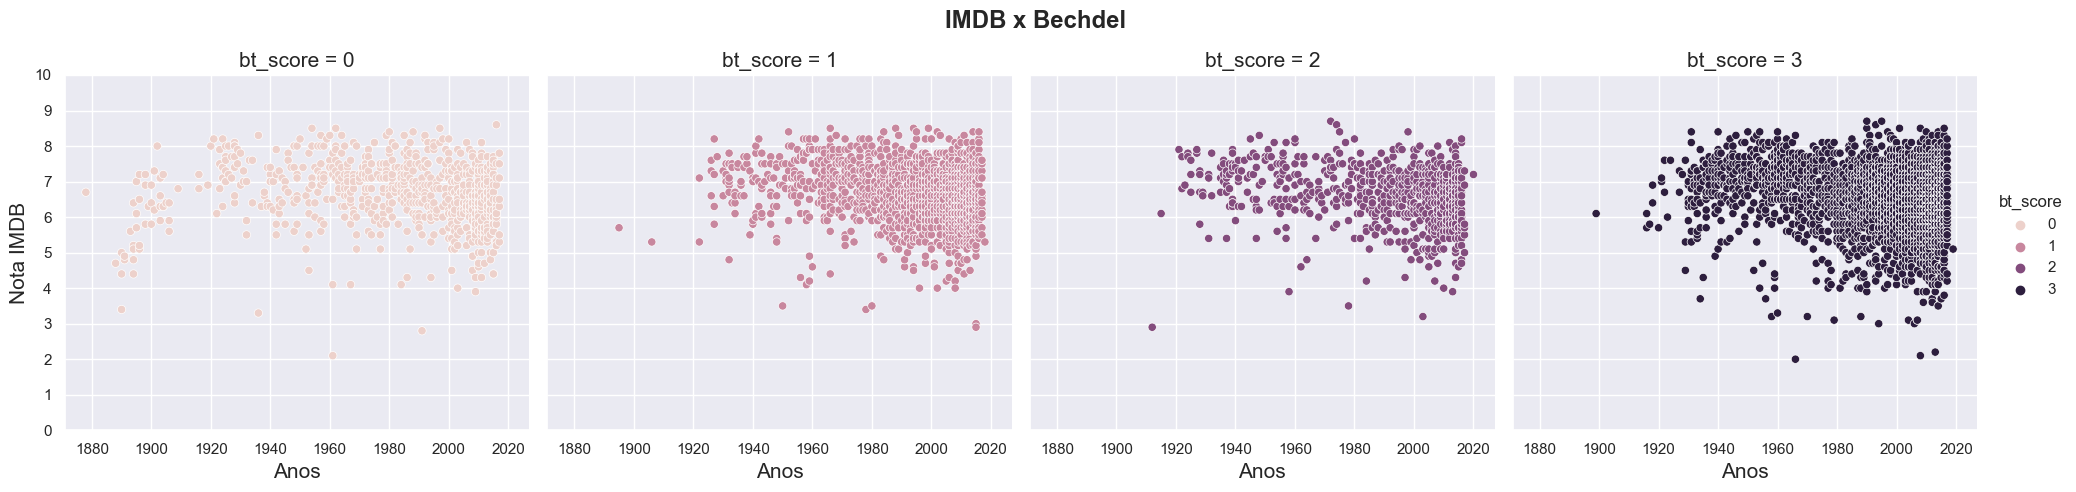

In [36]:
sns.set( rc = {'figure.figsize': (60, 60), 'axes.labelsize': 15})
g = sns.relplot(data = data, x = "year",  y = "vote_average", col = "bt_score", hue = "bt_score")
g.fig.suptitle("IMDB x Bechdel", fontsize = 'x-large', fontweight = 'bold')
g.fig.subplots_adjust(top = 0.85)
g.set_axis_labels("Anos" , "Nota IMDB")
g.set(ylim=(0, 10))
g.set(yticks=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))
plt.show()


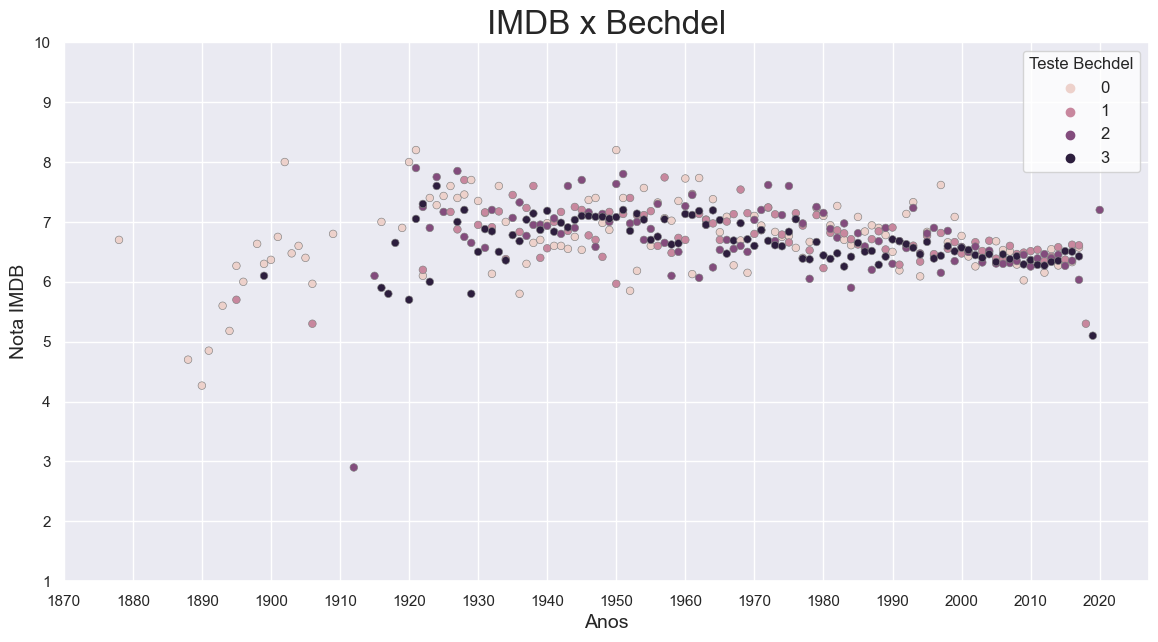

In [37]:
fig, ax = plt.subplots(figsize = (14 , 7))
sns.set_theme(style="ticks")
sns.set_style("white")
sns.scatterplot(y = "vote_average", x = 'year', hue = 'bt_score', data=imdb_bechdel, s = 30, edgecolor=".5")
plt.legend(title = "Teste Bechdel", fontsize = '12', title_fontsize = "12")
ax.set_xlabel("Anos", size = 14)
ax.set_ylabel("Nota IMDB", size = 14)
ax.set_title("IMDB x Bechdel", size = 24)
ax.set_xticks([1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.ticklabel_format(style='plain', axis='y')
plt.show()


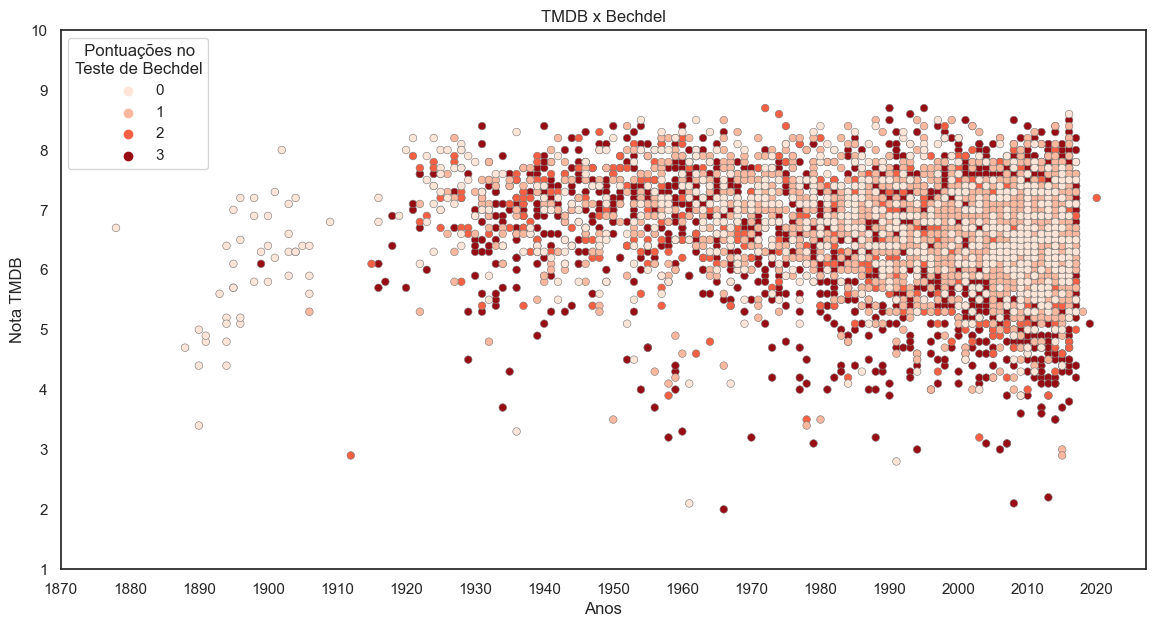

In [38]:
fig, ax = plt.subplots(figsize = (14 , 7))
sns.set_theme(style="ticks")
sns.set_style("white")
sns.scatterplot(y = "vote_average", x = 'year', hue = 'bt_score', data=data, s = 30, edgecolor=".5", palette=[cmap_reds(0.1), cmap_reds(0.26), cmap_reds(0.53), cmap_reds(0.9)])
plt.legend(title = "  Pontuações no\nTeste de Bechdel")
ax.set_xlabel("Anos")
ax.set_ylabel("Nota TMDB")
ax.set_title("TMDB x Bechdel")
ax.set_xticks(np.arange(1870, 2020+10, 10))
ax.set_yticks(np.arange(1, 10+1, 1))
plt.ticklabel_format(style='plain', axis='y')
plt.show()


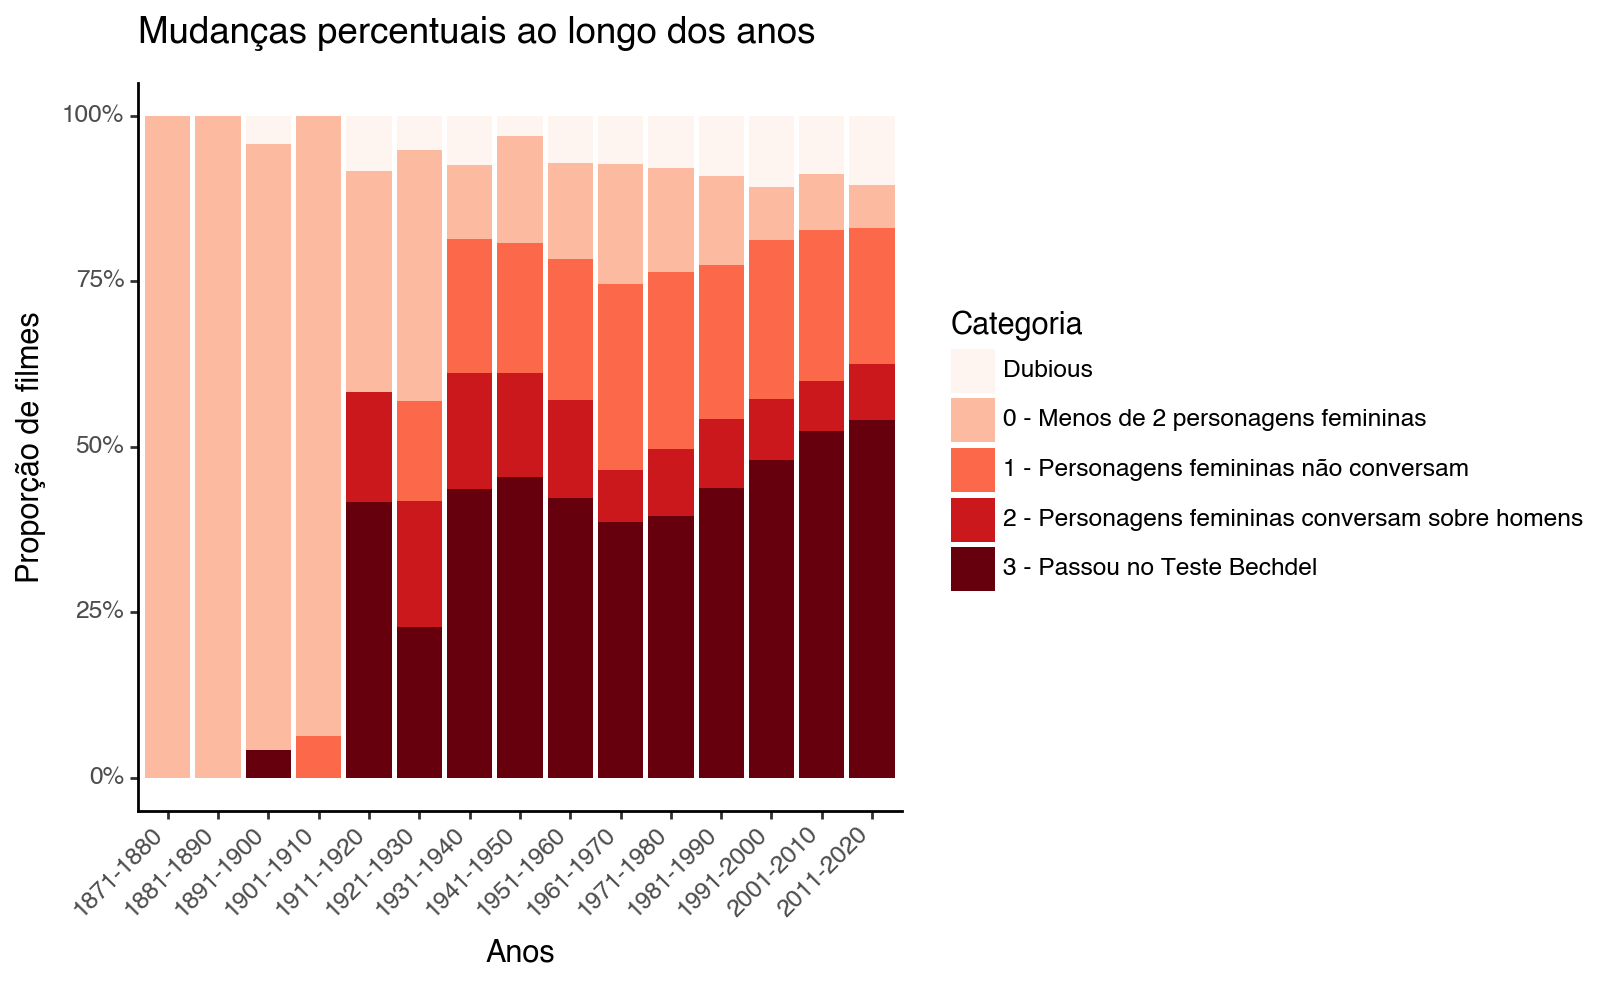

<Figure Size: (800 x 500)>

In [80]:
data2_df = data.copy()
data2_df = data2_df[data2_df['year'] < 2021]

for index, bt_score in data2_df['bt_score'].items():
    if data2_df.at[index, 'dubious'] == 1:
        data2_df.at[index, 'Categoria'] = 'Dubious'
    elif bt_score == 0:
        data2_df.at[index, 'Categoria'] = '0 - Menos de 2 personagens femininas'
    elif bt_score == 1:
        data2_df.at[index, 'Categoria'] = '1 - Personagens femininas não conversam'
    elif bt_score == 2:
        data2_df.at[index, 'Categoria'] = '2 - Personagens femininas conversam sobre homens'
    else:
        data2_df.at[index, 'Categoria'] = '3 - Passou no Teste Bechdel'

bechdel_df_ordered = data2_df.copy()
bechdel_df_ordered['Categoria'] = pd.Categorical(bechdel_df_ordered['Categoria'], categories=[
    'Dubious',
    '0 - Menos de 2 personagens femininas',
    '1 - Personagens femininas não conversam',
    '2 - Personagens femininas conversam sobre homens',
    '3 - Passou no Teste Bechdel'
], ordered=True)

for index, year in bechdel_df_ordered['year'].items():
    if (year % 10) == 0:
        interval_start = int(year - year%10 - 9)
    else:
        interval_start = int(year - year%10 + 1)
    interval_end = int(interval_start + 9)
    bechdel_df_ordered.at[index, 'year_interval'] = str(interval_start) + '-' + str(interval_end)

(ggplot(bechdel_df_ordered,
        aes(fill = 'Categoria', x = 'year_interval')) +
    geom_bar(position = "fill") +
    scale_y_continuous(labels=percent_format()) +
    scale_fill_manual(values = [hex_color_code(cmap_reds(0)), hex_color_code(cmap_reds(0.25)), hex_color_code(cmap_reds(0.5)), hex_color_code(cmap_reds(0.75)), hex_color_code(cmap_reds(1.0))]) +
    # geom_text(angle=45) +
    labs(
        title = 'Mudanças percentuais ao longo dos anos',
        x = 'Anos',
        y = 'Proporção de filmes'
    ) +
    theme_classic() +
    theme(figure_size=(8, 5), axis_text_x  = element_text(angle = 45, hjust = 1))
)


## **Novos gráficos**

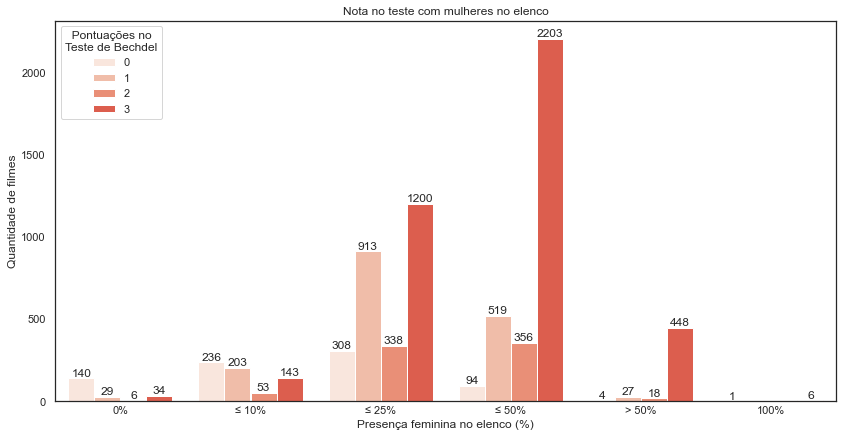

In [151]:
cast_df = pd.DataFrame(data)

cast_df['Cast'] = pd.NA

for index, row in cast_df.iterrows():
    Cast = 0
    if row['cast_female_representation'] == 0:
        Cast == 0
    if row['cast_female_representation'] != 0 and row['cast_female_representation'] <= 10:
        Cast += 1
    if row['cast_female_representation'] > 10 and row['cast_female_representation'] <= 25:
        Cast += 2
    if row['cast_female_representation'] > 25 and row['cast_female_representation'] <= 50:
        Cast += 3
    if row['cast_female_representation'] > 50 and row['cast_female_representation'] != 100:
        Cast += 4
    if row['cast_female_representation'] == 100:
        Cast += 5
    cast_df.loc[index, 'Cast'] = Cast

fig = plt.figure(figsize=(14, 7))
plot = sns.countplot(x ='Cast', hue = 'bt_score', data = cast_df, palette=[cmap_reds(0.1), cmap_reds(0.26), cmap_reds(0.42), cmap_reds(0.58), cmap_reds(0.74), cmap_reds(0.9)])
plt.title("Nota no teste com mulheres no elenco")
plt.xlabel("Presença feminina no elenco (%)")
plt.ylabel("Quantidade de filmes")
for i in range(4):
    plot.bar_label(plot.containers[i])
plt.legend(title = "  Pontuações no\nTeste de Bechdel")
plot.set_xticklabels(['0%', '≤ 10%', '≤ 25%', '≤ 50%', '> 50%', '100%'], ha='center', va='center')
plt.show()


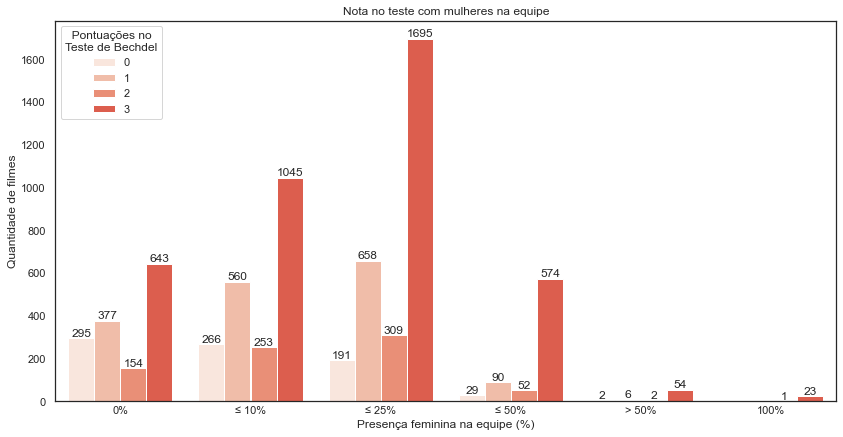

In [150]:
crew_df = pd.DataFrame(data)

crew_df['Crew'] = pd.NA

for index, row in crew_df.iterrows():
    crew = 0
    if row['crew_female_representation'] == 0:
        crew == 0
    if row['crew_female_representation'] != 0 and row['crew_female_representation'] <= 10:
        crew += 1
    if row['crew_female_representation'] > 10 and row['crew_female_representation'] <= 25:
        crew += 2
    if row['crew_female_representation'] > 25 and row['crew_female_representation'] <= 50:
        crew += 3
    if row['crew_female_representation'] > 50 and row['crew_female_representation'] != 100:
        crew += 4
    if row['crew_female_representation'] == 100:
        crew += 5
    crew_df.loc[index, 'Crew'] = crew

fig = plt.figure(figsize=(14, 7))
plot = sns.countplot(x ='Crew', hue = 'bt_score', data = crew_df, palette=[cmap_reds(0.1), cmap_reds(0.26), cmap_reds(0.42), cmap_reds(0.58), cmap_reds(0.74), cmap_reds(0.9)])
plt.title("Nota no teste com mulheres na equipe")
plt.xlabel("Presença feminina na equipe (%)")
plt.ylabel("Quantidade de filmes")
for i in range(4):
    plot.bar_label(plot.containers[i])
plt.legend(title = "  Pontuações no\nTeste de Bechdel")
plot.set_xticklabels(['0%', '≤ 10%', '≤ 25%', '≤ 50%', '> 50%', '100%'], ha='center', va='center')
plt.show()


In [120]:
crew_new_df = crew_df.loc[data['budget' and 'revenue'] > 0].copy()

for index, row in crew_new_df.iterrows():
    orçamento = 0
    if row['budget'] <= 500000:
        orçamento += 1
    if row['budget'] <= 1000000 and row['budget'] > 500000:
        orçamento += 2
    if row['budget'] <= 5000000 and row['budget'] > 1000000:
        orçamento += 3
    if row['budget'] <= 10000000 and row['budget'] > 5000000:
        orçamento += 4
    if row['budget'] <= 15000000 and row['budget'] > 10000000:
        orçamento += 5
    if row['budget'] <= 30000000 and row['budget'] > 15000000:
        orçamento += 6
    if row['budget'] <= 60000000 and row['budget'] > 30000000:
        orçamento += 7
    if row['budget'] > 60000000:
        orçamento += 8
    crew_new_df.loc[index, 'Orçamento'] = orçamento

crew_new_df['Bilheteria'] = pd.NA

for index, row in crew_new_df.iterrows():
    bilheteria = 0
    if row['revenue'] <= 500000:
        bilheteria += 1
    if row['revenue'] <= 1000000 and row['revenue'] > 500000:
        bilheteria += 2
    if row['revenue'] <= 5000000 and row['revenue'] > 1000000:
        bilheteria += 3
    if row['revenue'] <= 10000000 and row['revenue'] > 5000000:
        bilheteria += 4
    if row['revenue'] <= 15000000 and row['revenue'] > 10000000:
        bilheteria += 5
    if row['revenue'] <= 30000000 and row['revenue'] > 15000000:
        bilheteria += 6
    if row['revenue'] <= 60000000 and row['revenue'] > 30000000:
        bilheteria += 7
    if row['revenue'] > 60000000:
        bilheteria += 8
    crew_new_df.loc[index, 'Bilheteria'] = bilheteria


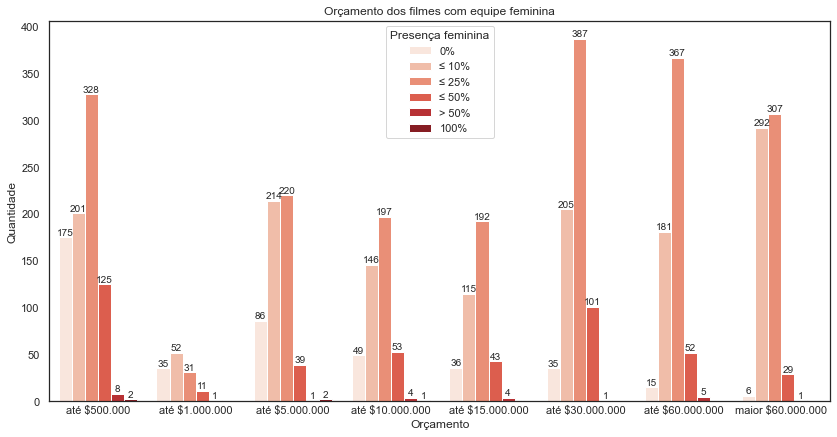

In [171]:
fig = plt.figure(figsize=(14, 7))
plot = sns.countplot(x='Orçamento', hue='Crew', data = crew_new_df, palette=[cmap_reds(0.1), cmap_reds(0.26), cmap_reds(0.42), cmap_reds(0.58), cmap_reds(0.74), cmap_reds(0.9)])
plt.title("Orçamento dos filmes com equipe feminina")
plt.xlabel("Orçamento")
plt.ylabel("Quantidade")
for i in range(6):
    plot.bar_label(plot.containers[i], fontsize=10)
plt.legend(labels = ['0%', '≤ 10%', '≤ 25%', '≤ 50%', '> 50%', '100%'], title = "Presença feminina")
plot.set_xticklabels(["até $500.000", "até $1.000.000", "até $5.000.000", "até $10.000.000", "até $15.000.000", "até $30.000.000", "até $60.000.000", "maior $60.000.000"], ha='center', va='center')
plt.show()


In [156]:
cast_new_df = cast_df.loc[data['budget' and 'revenue'] > 0].copy()

for index, row in cast_new_df.iterrows():
    orçamento = 0
    if row['budget'] <= 500000:
        orçamento += 1
    if row['budget'] <= 1000000 and row['budget'] > 500000:
        orçamento += 2
    if row['budget'] <= 5000000 and row['budget'] > 1000000:
        orçamento += 3
    if row['budget'] <= 10000000 and row['budget'] > 5000000:
        orçamento += 4
    if row['budget'] <= 15000000 and row['budget'] > 10000000:
        orçamento += 5
    if row['budget'] <= 30000000 and row['budget'] > 15000000:
        orçamento += 6
    if row['budget'] <= 60000000 and row['budget'] > 30000000:
        orçamento += 7
    if row['budget'] > 60000000:
        orçamento += 8
    cast_new_df.loc[index, 'Orçamento'] = orçamento

cast_new_df['Bilheteria'] = pd.NA

for index, row in cast_new_df.iterrows():
    bilheteria = 0
    if row['revenue'] <= 500000:
        bilheteria += 1
    if row['revenue'] <= 1000000 and row['revenue'] > 500000:
        bilheteria += 2
    if row['revenue'] <= 5000000 and row['revenue'] > 1000000:
        bilheteria += 3
    if row['revenue'] <= 10000000 and row['revenue'] > 5000000:
        bilheteria += 4
    if row['revenue'] <= 15000000 and row['revenue'] > 10000000:
        bilheteria += 5
    if row['revenue'] <= 30000000 and row['revenue'] > 15000000:
        bilheteria += 6
    if row['revenue'] <= 60000000 and row['revenue'] > 30000000:
        bilheteria += 7
    if row['revenue'] > 60000000:
        bilheteria += 8
    cast_new_df.loc[index, 'Bilheteria'] = bilheteria


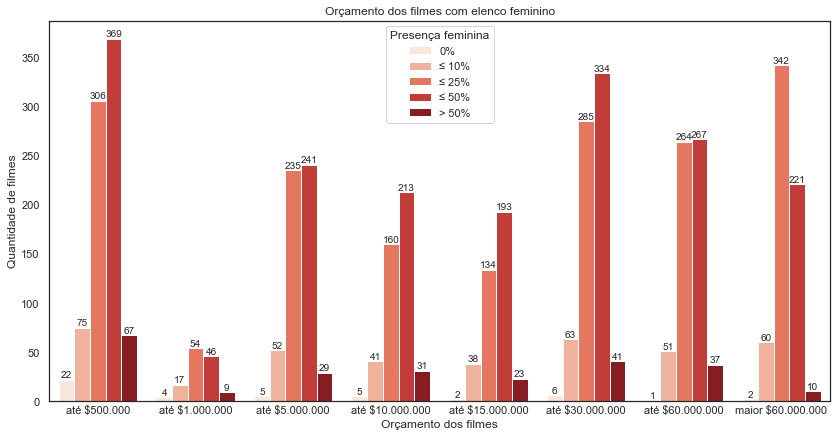

In [168]:
fig = plt.figure(figsize=(14, 7))
plot = sns.countplot(x='Orçamento', hue='Cast', data = cast_new_df, palette=[cmap_reds(0.1), cmap_reds(0.3), cmap_reds(0.5), cmap_reds(0.7), cmap_reds(0.9)])
plt.title("Orçamento dos filmes com elenco feminino")
plt.xlabel("Orçamento dos filmes")
plt.ylabel("Quantidade de filmes")
for i in range(5):
    plot.bar_label(plot.containers[i], fontsize=10)
plt.legend(labels = ['0%', '≤ 10%', '≤ 25%', '≤ 50%', '> 50%', '100%'], title = "Presença feminina")
plot.set_xticklabels(["até $500.000", "até $1.000.000", "até $5.000.000", "até $10.000.000", "até $15.000.000", "até $30.000.000", "até $60.000.000", "maior $60.000.000"], ha='center', va='center')
plt.show()
